# Clasificación multiclase con regresión logística
<p>Utilizaremos un [dataset](https://www.kaggle.com/datasets/sansuthi/dry-bean-dataset/code) que contiene judías de diferentes clases.
<img src="data/dry-bean-dataset-cover.png" width="400" />

In [55]:
import matplotlib.pyplot as plt
import numpy as numpy
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import seaborn as sns
sns.set()

df = pd.read_csv('./data/Dry_Bean.csv')
df['Class'].unique()

array(['SEKER', 'BARBUNYA', 'BOMBAY', 'CALI', 'HOROZ', 'SIRA', 'DERMASON'],
      dtype=object)

El dataset no contiene valores nulos

In [2]:
df.isnull().sum()

Area               0
Perimeter          0
MajorAxisLength    0
MinorAxisLength    0
AspectRation       0
Eccentricity       0
ConvexArea         0
EquivDiameter      0
Extent             0
Solidity           0
roundness          0
Compactness        0
ShapeFactor1       0
ShapeFactor2       0
ShapeFactor3       0
ShapeFactor4       0
Class              0
dtype: int64

Pero las clases están muy mal distribuidas

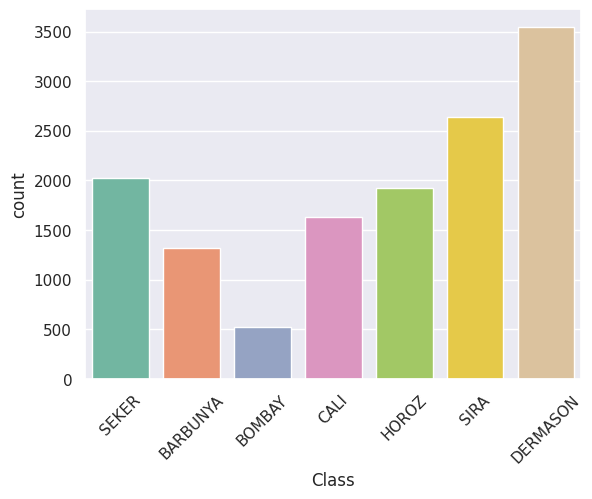

In [123]:
sns.countplot(x='Class', data=df, hue='Class')
plt.xticks(rotation=45)
plt.show()

Así que submuestreamos las clases mayoritarias hasta alcanzar una distribución más uniforme

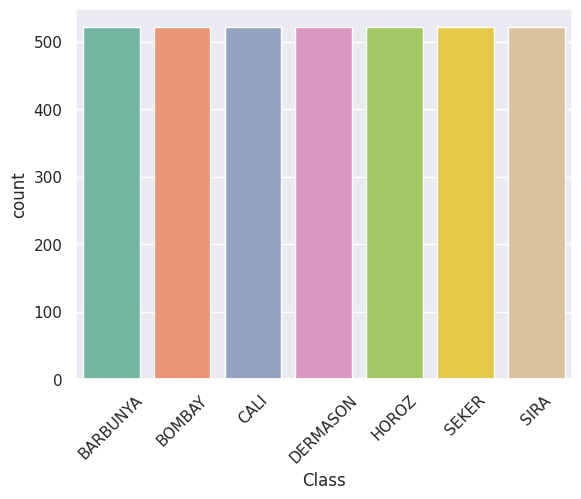

In [151]:
import imblearn
from imblearn.under_sampling import RandomUnderSampler

undersample = RandomUnderSampler(random_state=42)

X = df.drop('Class', axis=1)
y = df['Class']

# Solo funciona si y es una serie
X_over, y_over = undersample.fit_resample(X, y)

sns.countplot(x=y_over, data=df, hue=y_over)
plt.xticks(rotation=45)
plt.show()

Si te fijas el número de muestras es menor ahora. y_over es una serie y no un dataframe

In [152]:
# This is the shape of our dataset before balancing
y_over = y_over.to_frame()
df.shape, y_over.shape

((13611, 17), (3654, 1))

Convertimos las categorías a números pero OrdinalEncoder espera un dataframe y devuelve una puta matriz de numpy de dos dimensiones a menos que le ponga set_output que me devuelve un dataframe.

In [153]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder().fit(y_over).set_output(transform="pandas")
enc.categories_

[array(['BARBUNYA', 'BOMBAY', 'CALI', 'DERMASON', 'HOROZ', 'SEKER', 'SIRA'],
       dtype=object)]

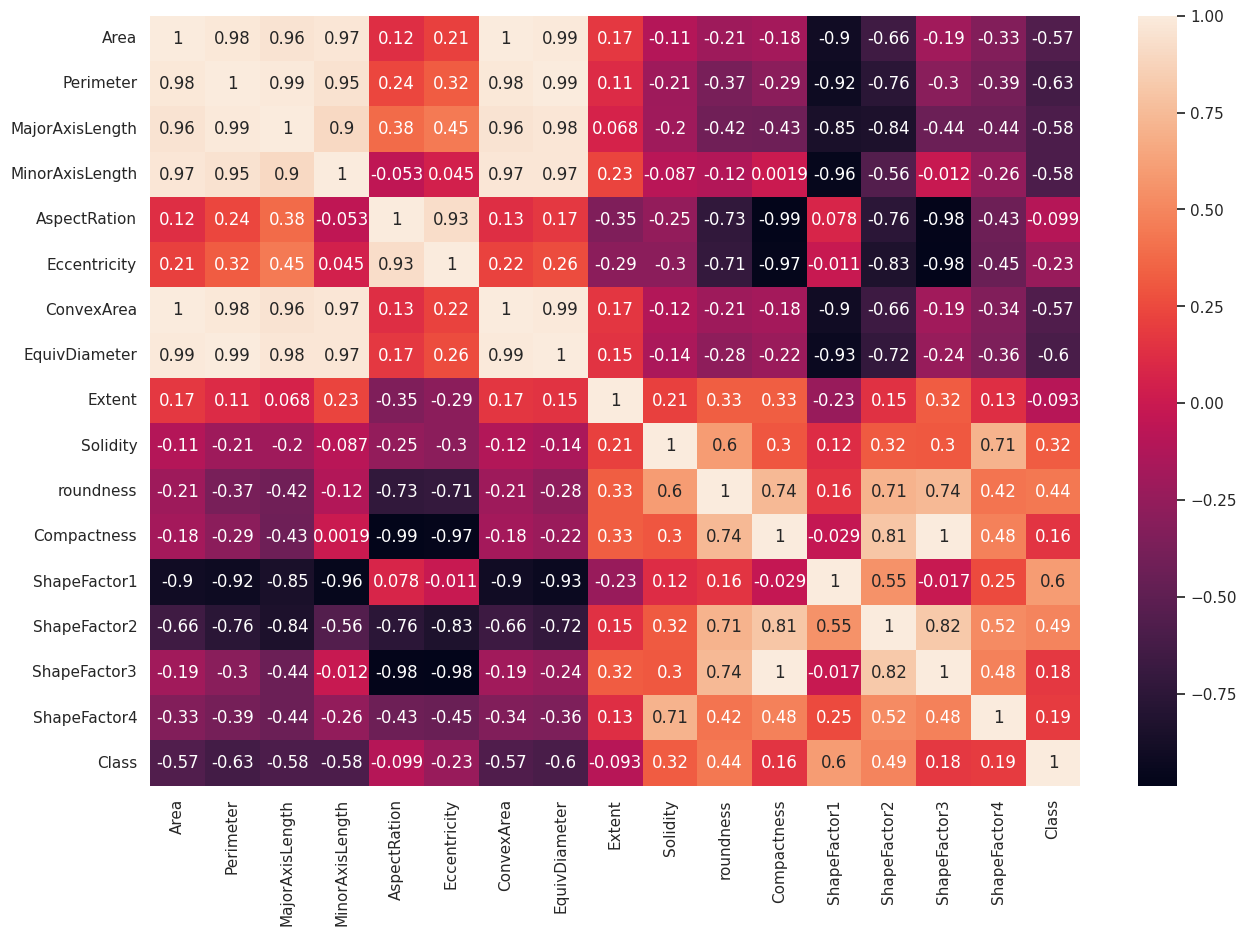

In [154]:
y_over = enc.transform(y_over)['Class']
df_dea = X_over
df_dea['Class'] = y_over

plt.figure(figsize=(15, 10))
sns.heatmap(df_dea.corr(), annot=True)
plt.show()

Como hay mucha correlación entre los atributos ConvexArea, EquivDiameter y los demás los eliminamos

In [155]:
# This columns may create an overfitted model
X_over.drop(['ConvexArea', 'EquivDiameter'], axis=1, inplace=True)

Dividimos entre train y test set y escalamos. Convertimos y_over a un vector porque ahora mismo es una matriz

In [156]:
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, random_state=42, shuffle=True, test_size=.2)
st_x = StandardScaler()
X_train = st_x.fit_transform(X_train)
X_test = st_x.transform(X_test)

## Aquí viene la chicha
Logistic Regression recurre a la clasificación multinomial (soft-max) cuando hay más de dos categorías. Este modelo es multiclase pero no multietiqueta. Si queremos un modelo que sea también multietiqueta hay que recurrir a un clasificador ovr (One vs. the rest). Scikit-learn implementa esto con una metaclase llamada [OneVsRestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) que recibe como parámetro un clasificador binario. Vamos a contruir un wrapper que me devuelva un estimador u otro en función del parámetro solver y multiclass. Hay que tener cuidado porque el solver 'liblinear' no dispone de opción multiclass en la regresión logística así que habrá que implementarlo siempre como un ovr. 

In [162]:
from sklearn.multiclass import OneVsRestClassifier
def logistic_model(C, solver_, multiclass_):
    if solver_== 'liblinear': multiclass_ = 'ovr';
    logistic_regression_model = LogisticRegression(random_state=42, solver=solver_, C=C, max_iter=5000)
    if multiclass_ == 'ovr': logistic_regression_model = OneVsRestClassifier(logistic_regression_model);
    return logistic_regression_model

Hacemos un barrido para distintos solvers y la opción multinomial, ovr

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'ovr liblinear'),
  Text(1, 0, 'ovr newton-cg'),
  Text(2, 0, 'ovr lbfgs'),
  Text(3, 0, 'ovr sag'),
  Text(4, 0, 'ovr saga'),
  Text(5, 0, 'multinomial liblinear'),
  Text(6, 0, 'multinomial newton-cg'),
  Text(7, 0, 'multinomial lbfgs'),
  Text(8, 0, 'multinomial sag'),
  Text(9, 0, 'multinomial saga')])

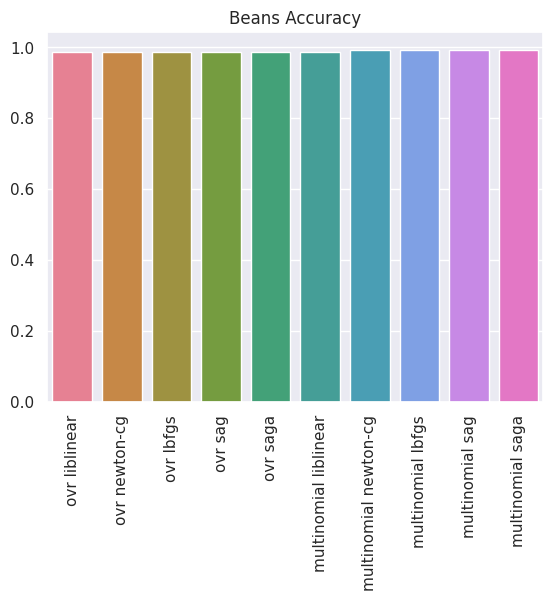

In [163]:
multiclass = ['ovr', 'multinomial']
solver_list = ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']
scores = []
params = []

for i in multiclass:
    for j in solver_list:
        try:
            model = logistic_model(1, j, i)
            model.fit(X_train, y_train)
            predictions = model.predict(X_test)
            params.append(i + ' ' + j)
            accuracy = accuracy_score(y_test, predictions)
            scores.append(accuracy)
        except:
            None

sns.barplot(x=params, y=scores, hue=params).set_title('Beans Accuracy')
plt.xticks(rotation=90)

Newton-cg multinomial es el que va mejor

[[128   0   0   0   0   0   0]
 [  0  98   0   0   0   0   0]
 [  0   0 102   1   0   0   0]
 [  0   0   0 105   0   0   0]
 [  0   0   2   0  94   0   0]
 [  0   0   0   0   0  89   2]
 [  0   0   0   0   0   0 110]]
0.9931600547195623


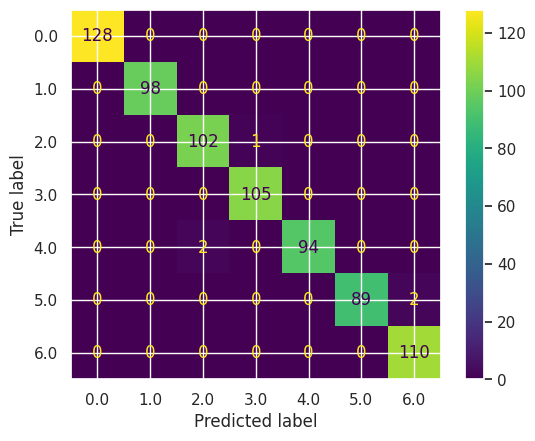

In [164]:
model = logistic_model(1, 'newton-cg', 'multinomial')
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print(confusion_matrix(y_test, predictions))
print(accuracy_score(y_test, predictions))


# Confusion Matrix Heatmap
cm = confusion_matrix(y_test, predictions, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()